# Dimensionality Reduction

In [1]:
from src.preprocessing import load_data, get_statistics, fill_empty_values
from src.outlier import interquartile_range
from src.visualize import get_histograms, get_boxplot
from src.normalize import normalize, check_norm
from pathlib import Path
from src.decomposition import svd, get_svd_info, covert, get_errors
import numpy as np

In [2]:
data_path = Path('data')
file_path = data_path / '23MAG_HW_1_v1.xls'

In [3]:
dataset = load_data(file_path)

In [4]:
get_statistics(dataset)

,Statistic,Age,Number of dependents,Salary,Years of stay in the region,Car price,Amount of credit
0,Mean,39.298507,2.086957,19861.764706,10.101449,20852.941176,198492.537313
1,Median,38.000000,2.000000,20250.000000,9.000000,20500.000000,200000.000000
2,Std,8.700427,0.996156,10169.342711,4.932321,10692.813469,99837.348500
3,Quantile (25%),34.000000,1.000000,11125.000000,7.000000,12000.000000,118000.000000
4,Quantile (50%),38.000000,2.000000,20250.000000,9.000000,20500.000000,200000.000000
5,Quantile (75%),46.000000,3.000000,27125.000000,14.000000,28000.000000,265500.000000


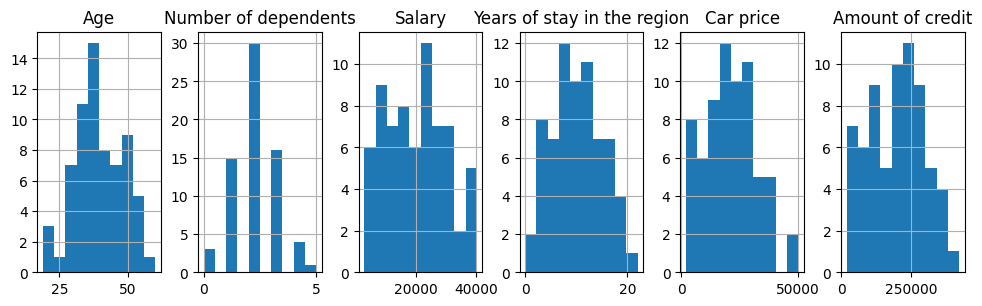

In [5]:
get_histograms(dataset)

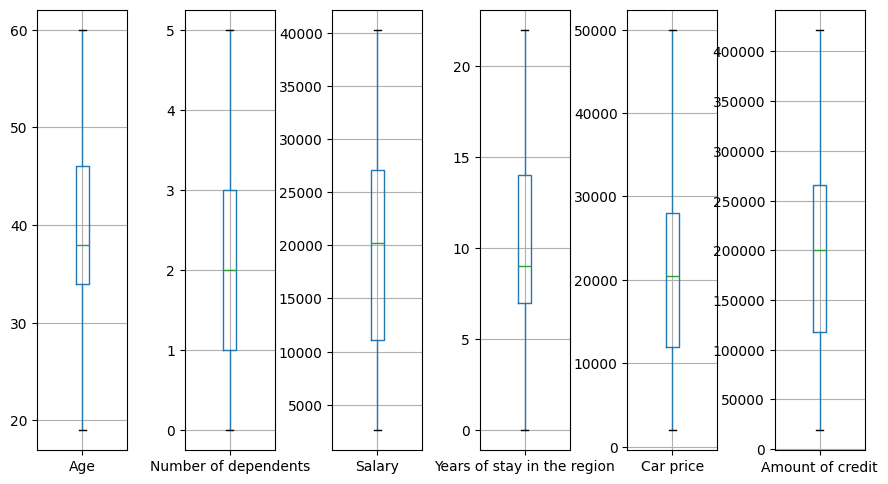

In [6]:
get_boxplot(dataset)

In [7]:
dataset = fill_empty_values(dataset)

In [8]:
dataset = interquartile_range(dataset)

In [9]:
data_z = normalize(dataset)
check_norm(data_z)
matrix_z = data_z.to_numpy()

In [10]:
matrix_u, singular_values, matrix_v = svd(matrix_z)
get_svd_info(singular_values)

,0
Singular values,"[2.48, 0.7, 0.53, 0.22, 0.15, 0.11, 0.07]"
Total variance,7.0
Explained variances,"[0.88, 0.07, 0.04, 0.01, 0.0, 0.0, 0.0]"
Explained variance (via 1 components),0.88
Explained variance (via 2 components),0.95
Explained variance (via 3 components),0.99
Explained variance (via 4 components),0.99
Explained variance (via 5 components),1.0
Explained variance (via 6 components),1.0


> Note our data could be explained via 2 components

In [11]:
np.around(matrix_z[:5], 2)

array([[0.  , 0.11, 0.11, 0.12, 0.09, 0.12, 0.11],
       [0.  , 0.14, 0.11, 0.06, 0.15, 0.06, 0.06],
       [0.01, 0.12, 0.11, 0.12, 0.1 , 0.12, 0.12],
       [0.01, 0.15, 0.16, 0.09, 0.19, 0.1 , 0.09],
       [0.01, 0.12, 0.11, 0.11, 0.12, 0.03, 0.03]])

In [12]:
approximated_matrix_z = covert(matrix_u, singular_values, matrix_v, 2)
np.around(approximated_matrix_z[:5], 2)

array([[0.08, 0.09, 0.09, 0.11, 0.07, 0.11, 0.11],
       [0.1 , 0.11, 0.1 , 0.06, 0.12, 0.06, 0.06],
       [0.08, 0.09, 0.09, 0.12, 0.08, 0.12, 0.12],
       [0.12, 0.13, 0.13, 0.09, 0.14, 0.09, 0.09],
       [0.08, 0.09, 0.09, 0.05, 0.1 , 0.06, 0.06]])

In [13]:
get_errors(matrix_z, approximated_matrix_z)

,Error,Result
0,Frobenius norm error,0.369106
1,Spectral norm error,0.527780
2,Relative Frobenius norm error,0.052729
